In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
import pandas as pd
from PIL import Image
import numpy as np


In [2]:
df = pd.read_csv('StenosisDetection/train_labels.csv', usecols=['filename','xmax','ymax','xmin', 'ymin'])

In [3]:
image_size = 224  
images, targets = [], []

top_left_x_collection = []
top_left_y_collection = []
bottom_right_x_collection = []
bottom_right_y_collection = [] 


In [4]:
for index, row in df.iterrows():
    image = keras.utils.load_img(
        'StenosisDetection/dataset/'+row['filename'],
    )

    (w, h) = image.size[:2]
    image = image.resize((224, 224))
    images.append(keras.utils.img_to_array(image))
    
    
    top_left_x, top_left_y = row['xmax'], row['ymax']
    bottom_right_x, bottom_right_y = row['xmin'], row['ymin']
    
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )


In [5]:
df_test = pd.read_csv('StenosisDetection/test_labels.csv', usecols=['filename','xmax','ymax','xmin', 'ymin'])


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])


In [7]:
image_size = 224  
images_test, targets_test = [], [] 


In [8]:
for index, row in df_test.iterrows():
    image = keras.utils.load_img(
        'StenosisDetection/dataset/'+row['filename'],
    )

    (w, h) = image.size[:2]
    image = image.resize((224, 224))
    images_test.append(keras.utils.img_to_array(image))
    
    
    top_left_x, top_left_y = row['xmax'], row['ymax']
    bottom_right_x, bottom_right_y = row['xmin'], row['ymin']
    
    targets_test.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )


In [9]:
(x_train), (y_train) = (
    np.asarray(images[: int(len(images))]),
    np.asarray(targets[: int(len(targets))]),
)
(x_test), (y_test) = (
    np.asarray(images_test[: int(len(images_test))]),
    np.asarray(targets_test[: int(len(targets_test))]),
)


In [10]:
y_train.shape

(7493, 4)

In [11]:
y_train[0]

array([0.3525 , 0.24   , 0.29375, 0.195  ])

In [12]:
y_train.shape

(7493, 4)

In [13]:
patch_size = 32

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(patches.shape)

Metal device set to: Apple M1 Pro
(1, 49, 3072)


2023-02-10 09:57:29.178933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-10 09:57:29.184083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [15]:
# x = keras.layers.InputShape()
# x = keras.layers.Patches()(x)
# x = PatchEncoder(patches)


In [16]:
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


In [17]:
from tensorflow.keras.applications import inception_v3


In [18]:
def basemodel(weights='imagenet', input_shape=(224, 224, 1), unfreeze=True, unfreeze_from=15, include_top=False):
    base_model = inception_v3.InceptionV3(
    include_top=include_top,
    weights=weights,
    input_shape=input_shape
    )
    return base_model


In [19]:
def intermediatemodel(base_model, output_index_layer, unfreeze=False, unfreeze_from=0):
    intermediate_layer_model = keras.Model(inputs=base_model.input,
                                     outputs=base_model.get_layer(index=output_index_layer).output)

    i = 0
    for layer in intermediate_layer_model.layers:
        print(layer.name)
        print(i)
        i += 1
        layer.trainable = False

    if unfreeze:
        for layer in intermediate_layer_model.layers[unfreeze_from:]:
            layer.trainable = True

    for layer in intermediate_layer_model.layers:
        print("{}: {}".format(layer, layer.trainable))

    return intermediate_layer_model



In [20]:

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
# def predictionmodel(base_model, dense_sizes=[128], dense_activations=['relu'],
#                     dense_kernel_inits=['random_uniform'], dropout_p=[0.5],
#                     pooling='avg', classes=1,
#                     class_activation='sigmoid'):
#     input_shape = base_model.output.shape
#     model = Sequential()
#     model.add(Conv2D(8, (7, 7), padding='same', activation='relu', input_shape=(input_shape[1],input_shape[2],input_shape[3])))
#     model.add(Dropout(0.5))
#     model.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
#     model.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(16, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
#     model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='random_uniform'))


#         predictions = Dense(classes, activation=class_activation, name='Output')(x)

#     return model


In [21]:
def predictionmodel(base_model, dense_sizes=[128], dense_activations=['relu'],
                    dense_kernel_inits=['random_uniform'], dropout_p=[0.5],
                    pooling='avg', classes=1,
                    class_activation='sigmoid'):
    x = base_model.output
#     x= layers.Flatten()(x)

# #     x= layers.Dropout(0.3)(x)
#     # Add MLP.
#     x= layers.Dense(256)(x)
#     x= layers.Dropout(0.1)(x)
#     x= layers.Dense(128)(x)
#     x= layers.Dropout(0.1)(x)

#     predictions = layers.Dense(4)(x)
    
    
    
    
#     x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2,2))(x)
#     x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     predictions = layers.Dense(4, activation='sigmoid')(x)


#     x = keras.layers.Flatten()(x)

    for i, (ds, da, dki, dop) in enumerate(zip(dense_sizes, dense_activations, dense_kernel_inits, dropout_p)):
        x = Dense(ds, activation=da, kernel_initializer=dki)(x)
        name = 'Dropout_Regularization_' + str(i)
        x = Dropout(dop, name=name)(x)
#     predictions = Dense(classes, activation=class_activation, name='Output')(x)

    predictions = layers.Dense(4, activation='sigmoid')(x)

    
    
    return predictions


In [22]:
base_model = basemodel(input_shape=(224, 224, 3))
len(base_model.layers)

311

In [23]:
base_model.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'mixed10')>

In [24]:
# midmodel = intermediatemodel(base_model, 86)

midmodel = intermediatemodel(base_model, len(base_model.layers) - 1)



input_1
0
conv2d
1
batch_normalization
2
activation
3
conv2d_1
4
batch_normalization_1
5
activation_1
6
conv2d_2
7
batch_normalization_2
8
activation_2
9
max_pooling2d
10
conv2d_3
11
batch_normalization_3
12
activation_3
13
conv2d_4
14
batch_normalization_4
15
activation_4
16
max_pooling2d_1
17
conv2d_8
18
batch_normalization_8
19
activation_8
20
conv2d_6
21
conv2d_9
22
batch_normalization_6
23
batch_normalization_9
24
activation_6
25
activation_9
26
average_pooling2d
27
conv2d_5
28
conv2d_7
29
conv2d_10
30
conv2d_11
31
batch_normalization_5
32
batch_normalization_7
33
batch_normalization_10
34
batch_normalization_11
35
activation_5
36
activation_7
37
activation_10
38
activation_11
39
mixed0
40
conv2d_15
41
batch_normalization_15
42
activation_15
43
conv2d_13
44
conv2d_16
45
batch_normalization_13
46
batch_normalization_16
47
activation_13
48
activation_16
49
average_pooling2d_1
50
conv2d_12
51
conv2d_14
52
conv2d_17
53
conv2d_18
54
batch_normalization_12
55
batch_normalization_14
56
b

In [25]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [26]:
midmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [27]:
headmodel = predictionmodel(midmodel, pooling=None)


In [28]:
model = keras.Model(inputs=midmodel.input, outputs=headmodel)


In [29]:
model.output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_2')>

In [30]:
y_train.shape

(7493, 4)

In [31]:
base_model_input_shape = model.input_shape
model.build(input_shape=base_model_input_shape)

In [32]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
                mode='min',
                monitor='val_loss',
                factor=0.1,
                min_lr=5e-7,
                patience=10,
                verbose=1)
    

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
                monitor="val_loss",
                patience=10,
                mode="min",
                restore_best_weights=True,
                verbose=1)

In [34]:
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=0.001,
                      momentum=0.9,
                      name="SGD")

In [35]:
model.compile(loss='binary_crossentropy',metrics=['acc'],optimizer=keras.optimizers.Adam(lr=0.2))

/Users/ddyrga/.pyenv/versions/3.10.8/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
#mse

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [38]:
model.fit(x=x_train, y=y_train, epochs=4, batch_size=64)

Epoch 1/4


2023-02-10 09:57:35.623273: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-10 09:57:37.856429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - 29s 218ms/step - loss: 170.1336 - acc: 0.6303
Epoch 2/4
118/118 [==============================] - 26s 222ms/step - loss: 0.6521 - acc: 0.6905
Epoch 3/4
118/118 [==============================] - 25s 213ms/step - loss: 0.6522 - acc: 0.6905
Epoch 4/4
118/118 [==============================] - 25s 210ms/step - loss: 0.6523 - acc: 0.6904


In [39]:
# for layer in model.layers[:-6]:
#     layer.trainable = True
# model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=15)

2023-02-10 09:59:21.057067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
[0.42498988 0.35896075 0.3570869  0.30152228]
[0.41    0.4975  0.36    0.46125]
1/1 [==============================] - 0s 32ms/step
[0.42498988 0.35896075 0.3570869  0.30152228]
[0.2525 0.2525 0.2075 0.2   ]
1/1 [==============================] - 0s 33ms/step
[0.42498988 0.35896075 0.3570869  0.30152228]
[0.615   0.47375 0.57625 0.42125]
1/1 [==============================] - 0s 29ms/step
[0.42498988 0.35896075 0.3570869  0.30152228]
[0.36914062 0.30859375 0.25       0.265625  ]
1/1 [==============================] - 0s 27ms/step
[0.42498988 0.35896075 0.3570869  0.30152228]
[0.43875 0.2875  0.40375 0.22125]
1/1 [==============================] - 0s 25ms/step
[0.42498988 0.35896075 0.3570869  0.30152228]
[0.2575  0.40625 0.21625 0.325  ]
1/1 [==============================] - 0s 27ms/step
[0.42498988 0.35896075 0.3570869  0.30152228]
[0.859375   0.453125   0.79296875 0.39257812]
1/1 [==============================] - 0s 26ms/step
[0.424

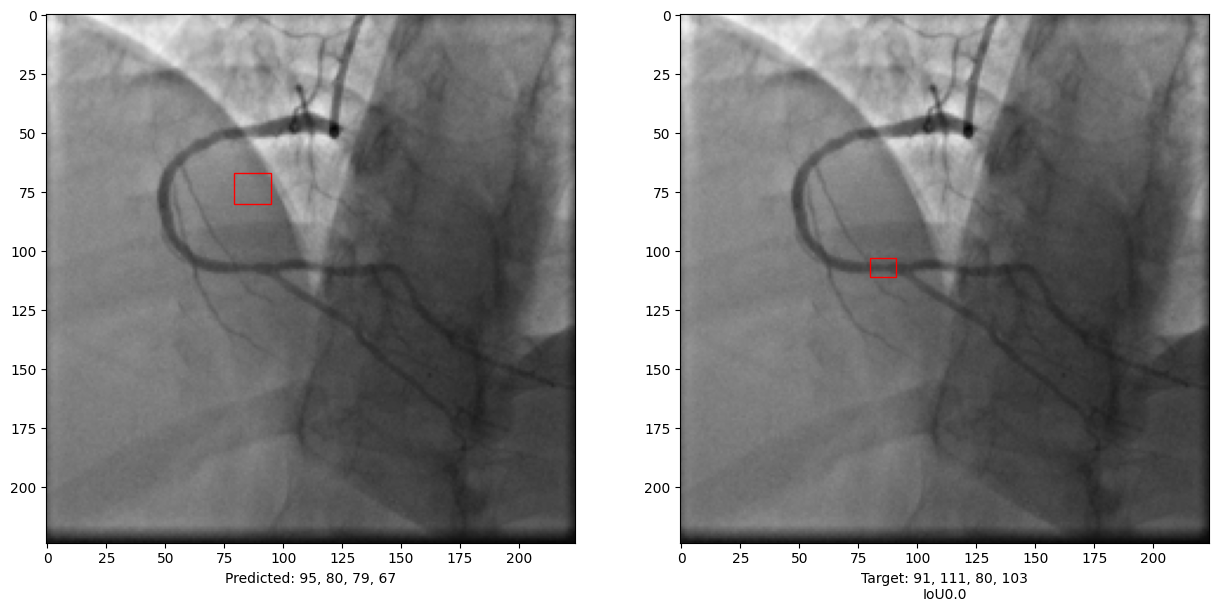

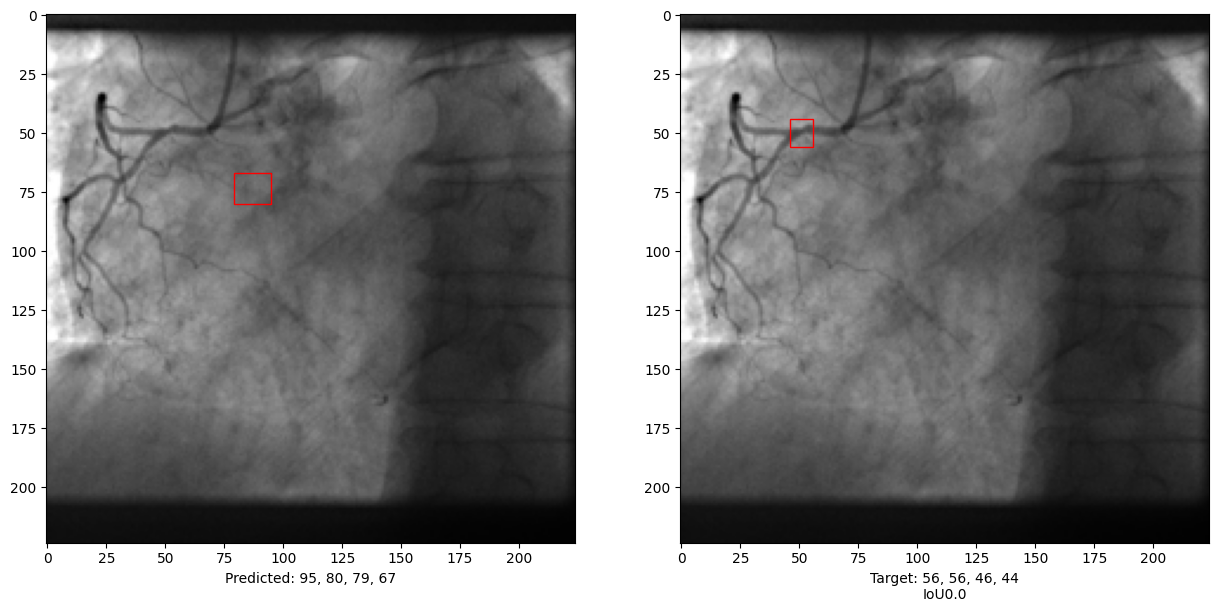

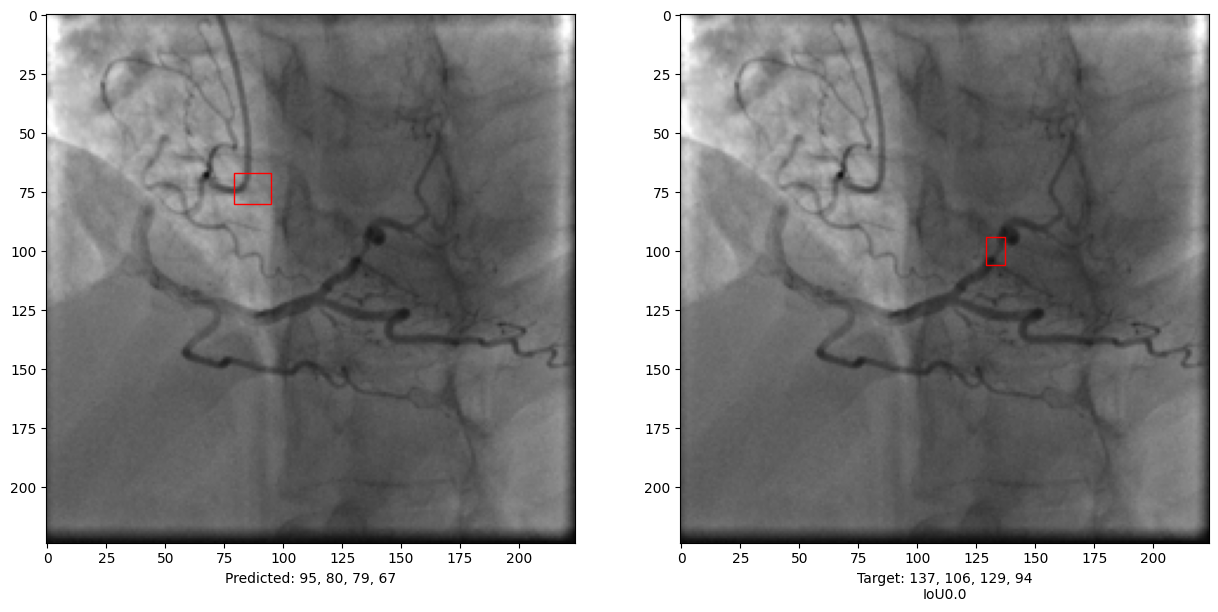

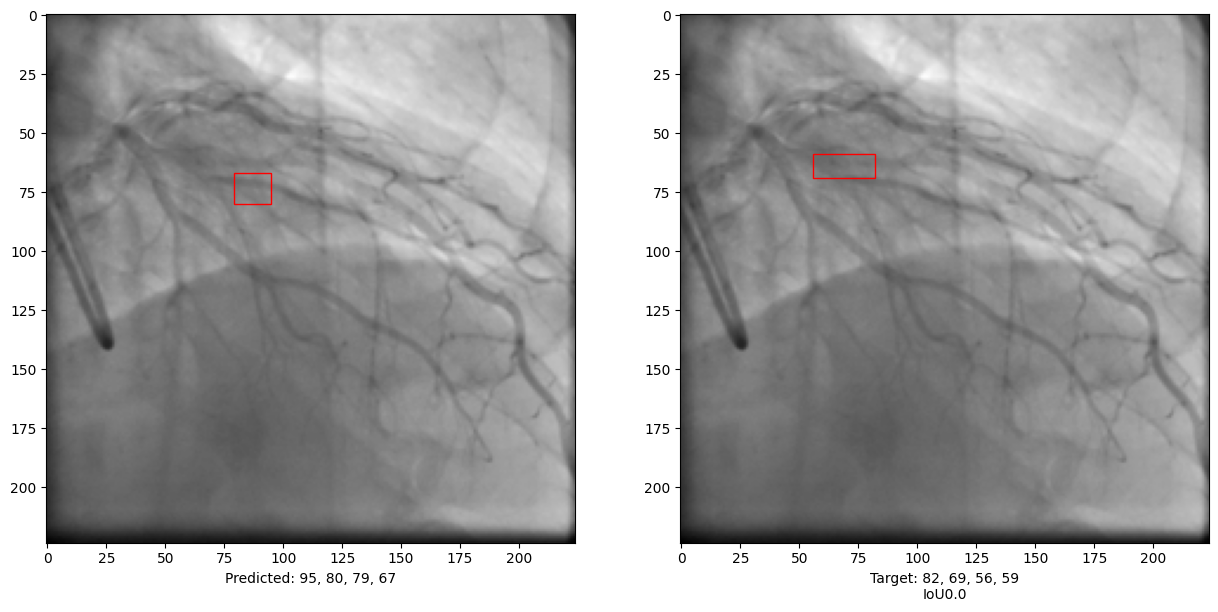

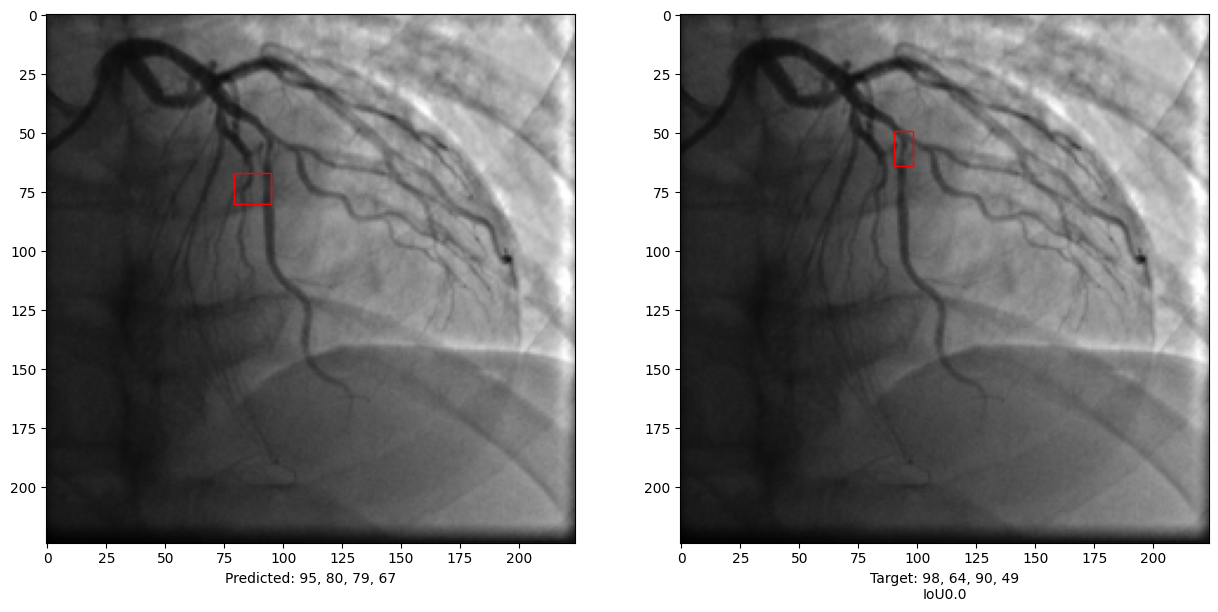

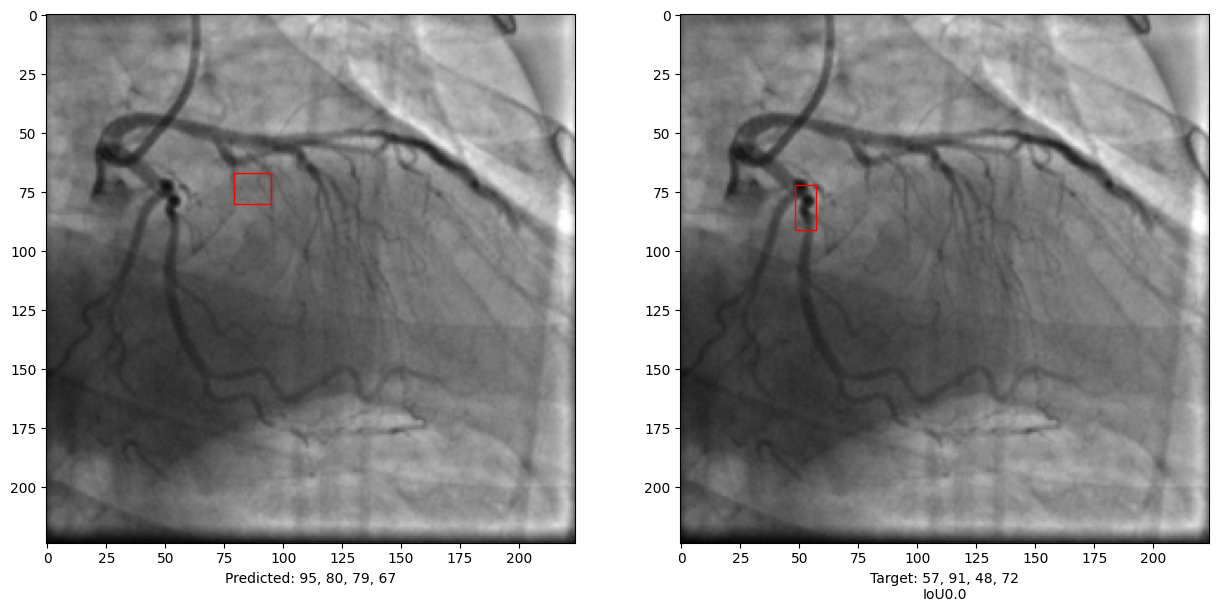

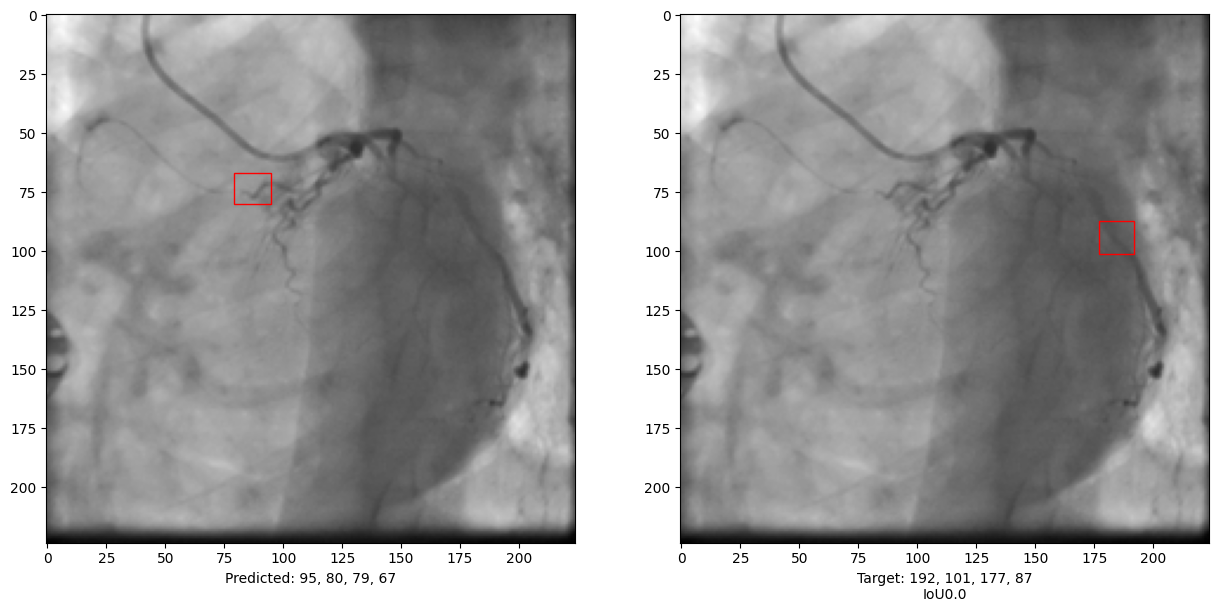

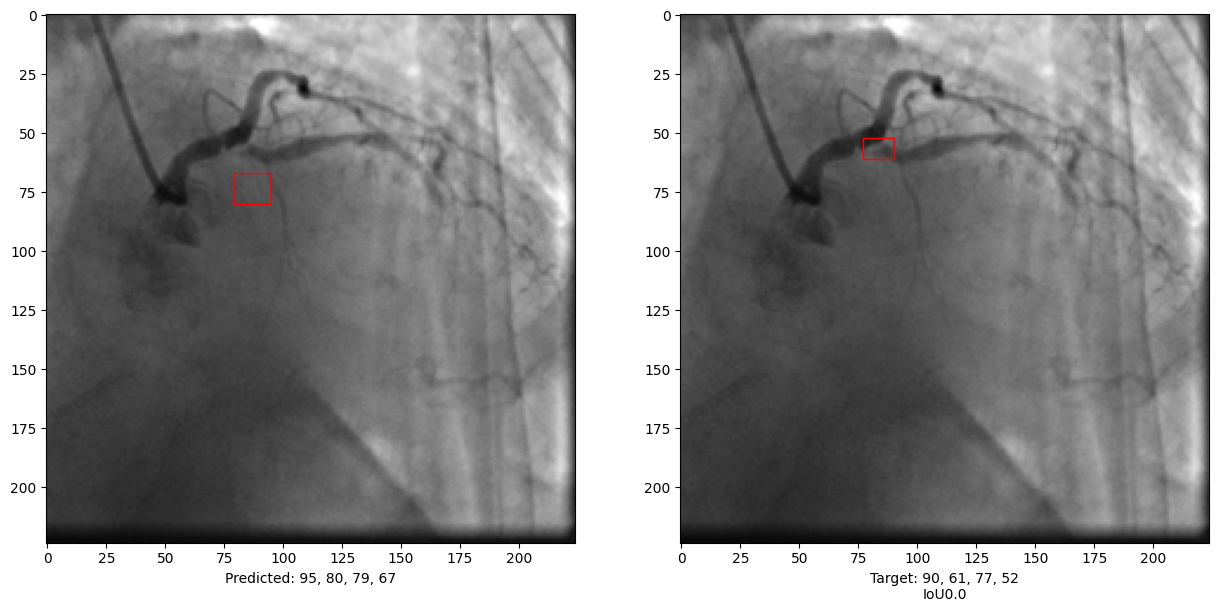

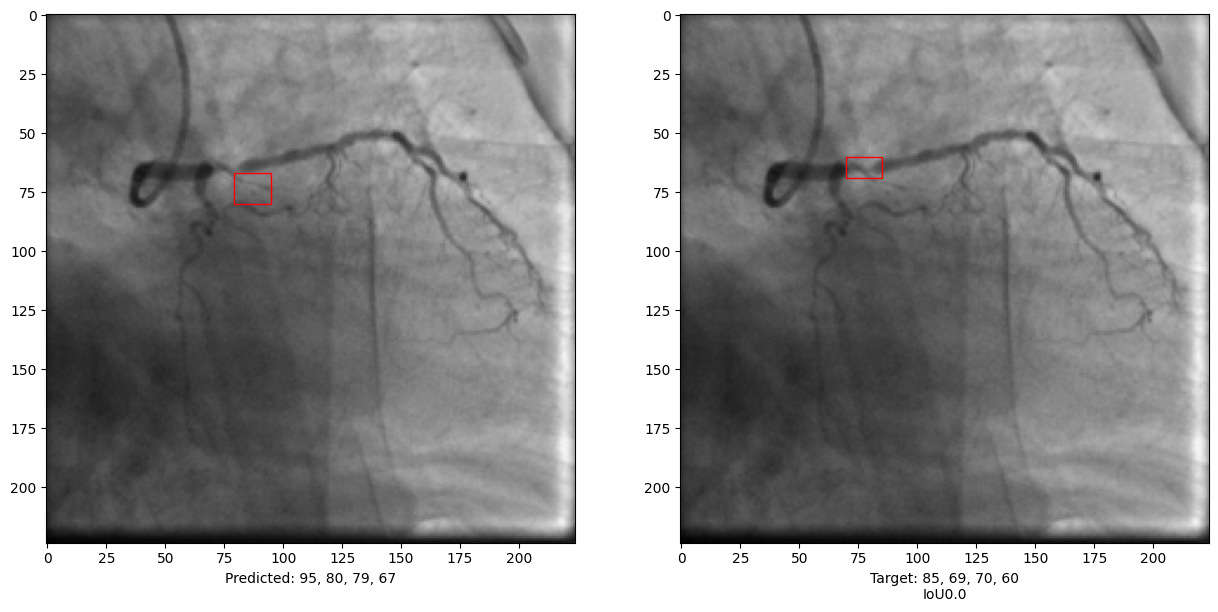

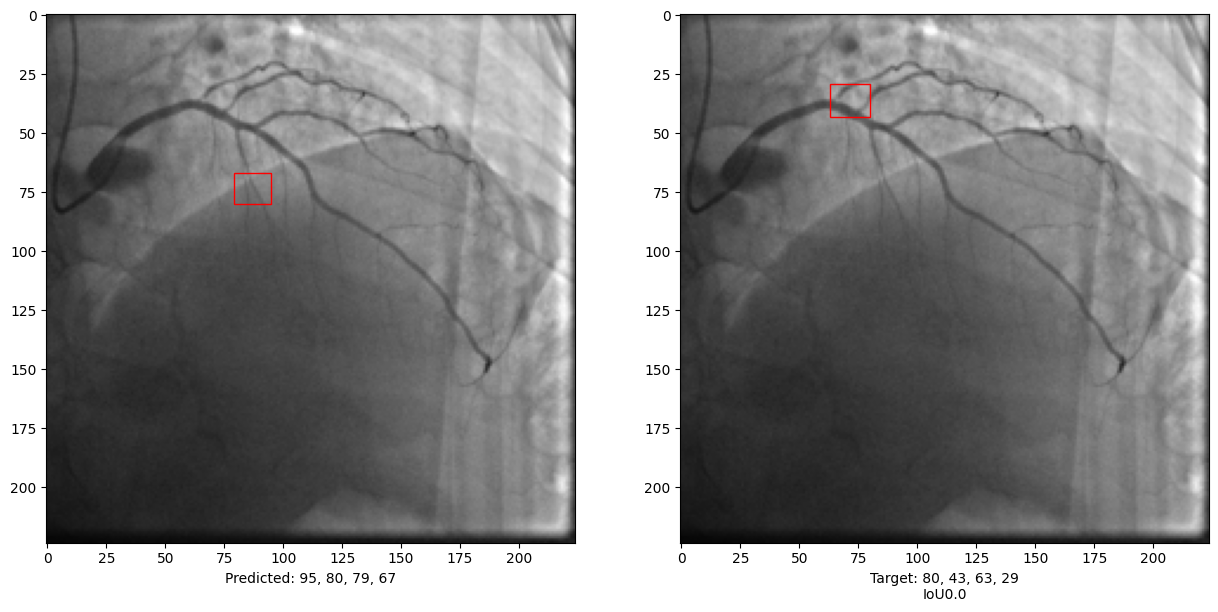

In [40]:
import matplotlib.patches as patches

def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )


    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model.predict(input_image)[0]
    print(preds)

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )
    print(y_test[i])

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)

    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
# print("mean_iou: " + str(mean_iou))

plt.show()